<a href="https://colab.research.google.com/github/yeabwang/Human-Emotions-Detection/blob/main/Human_emotion_detection_hugging_face_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Multiply, Conv2D, MaxPool2D, Dense,
#                                      Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
#                                      Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,DepthwiseConv2D,
#                                      RandomContrast, Rescaling, Resizing, Reshape, ReLU)
# from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
#                                         ModelCheckpoint, ReduceLROnPlateau)
# from tensorflow.keras.regularizers  import L2, L1
# from tensorflow.train import BytesList, FloatList, Int64List
# from tensorflow.train import Example, Features, Feature
from google.colab import drive
from transformers import TFViTModel

In [ ]:
# Load the dataset
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

!pip install kaggle --upgrade
!pip install --upgrade pip

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!unzip "human-emotions-datasethes.zip" -d "/content/dataset"

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "MODEL_IM_SIZE": 224,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 2278 files belonging to 3 classes.


In [ ]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor = (-0.025, 0.025)),
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomContrast(factor = 0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

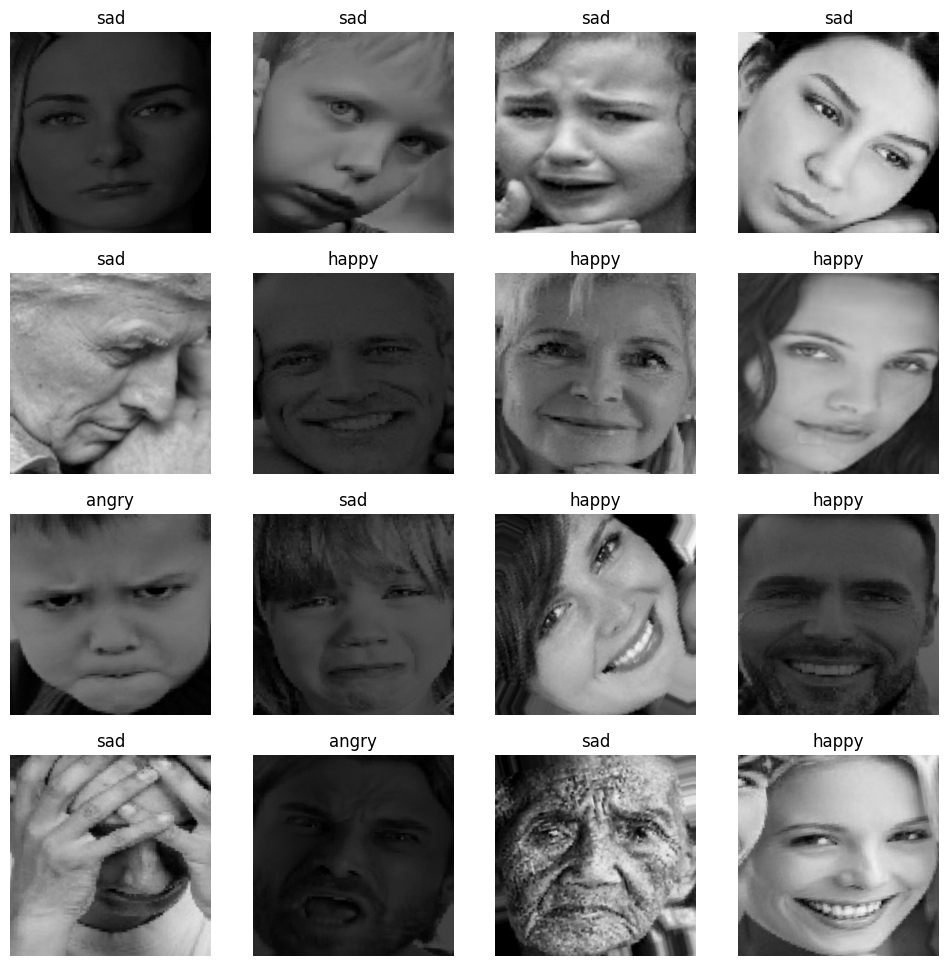

In [ ]:
plt.figure(figsize=(12,12))

for sample in mixed_dataset.take(1):
    (images, labels) = sample[0]
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy() / 255.0)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/126954.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [ ]:
patches = tf.image.extract_patches(images = tf.expand_dims(test_image, axis = 0),
                           sizes = [1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides = [1,CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates = [1,1,1,1],
                           padding= "VALID"     )

patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
print(patches.shape)

(1, 256, 768)


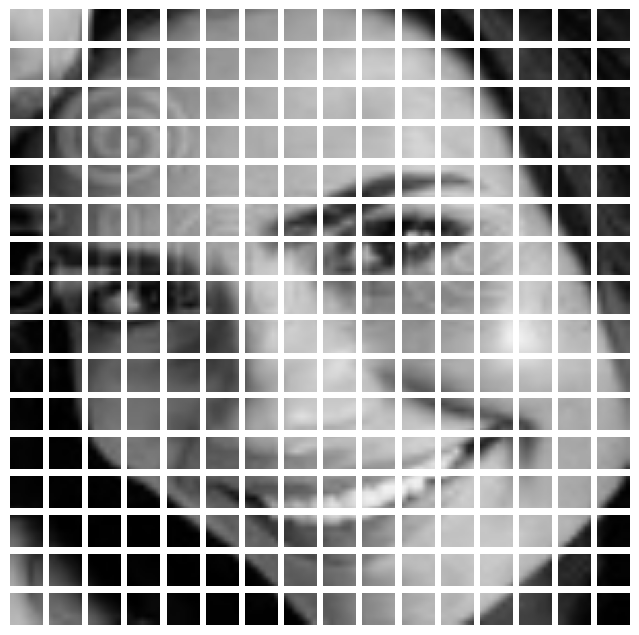

In [ ]:
plt.figure(figsize=(8,8))

for i in range(patches.shape[1]):
  ax = plt.subplot(16,16, i+1)
  plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
  plt.axis("off")

## Hugging face ViT

In [ ]:
resize_rescale_hf = tf.keras.Sequential([
       tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Permute((3,1,2))
])

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs =  tf.keras.layers.Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
# Pass the processed input through the ViT model.
# `base_model.vit(x)[0]` returns the full hidden states (last_hidden_state).
# `[:,0,:]` extracts the [CLS] token representation from the last hidden state.
# The [CLS] token is a special token used in transformer architectures to represent the
# entire image, serving as a high-level feature representation.
x = base_model.vit(x)[0][:,0,:]

output =  tf.keras.layers.Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

hf_model.summary()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


ValueError: Exception encountered when calling layer 'vit' (type TFViTMainLayer).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'vit' (type TFViTMainLayer):
  • pixel_values=<KerasTensor shape=(None, 3, 224, 224), dtype=float32, sparse=False, name=keras_tensor_5>
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False